#MNIST digit recognition using Stochastic Gradient Boosting in **scikit-learn**

#> Kaggle digit-recognition contest
---

In [1]:
from __future__ import division
import os, time, math
import cPickle as pickle
import multiprocessing

import matplotlib.pyplot as plt
import numpy as np
import csv

# my function to print a grid of square images
from print_imgs import print_imgs

from sklearn.ensemble         import GradientBoostingClassifier

from sklearn.cross_validation import StratifiedKFold, KFold
from sklearn.cross_validation import train_test_split
from sklearn.grid_search      import GridSearchCV

from sklearn.metrics          import classification_report, confusion_matrix, f1_score
from sklearn.externals        import joblib

np.random.seed(seed=1009)

%matplotlib inline

In [2]:
#%qtconsole

##Where's the data?

In [3]:
file_path = '../kaggle/data/'

DESKEWED = True
if DESKEWED:
    train_img_filename = 'kaggle_trainX_deskewed.csv'
    test_img_filename  = 'kaggle_testX_deskewed.csv'
else:
    train_img_filename = 'kaggle_trainX.csv'
    test_img_filename  = 'kaggle_testX.csv'
    
train_label_filename   = 'kaggle_trainY.csv'
test_label_filename    = None                  # not provided

##How much of the data will we use?

In [4]:
portion = 1.0  # set to 1.0 for all of it less than 1.0 for less

##Read the training images and labels

In [5]:
with open(file_path + train_img_filename,'r') as f:
    data_iter = csv.reader(f, delimiter = ',')
    data      = [data for data in data_iter]
trainX = np.asarray(data, dtype = np.float64)  

trainX = trainX[:portion*trainX.shape[0]]

print("trainX shape: {0}".format(trainX.shape))

with open(file_path + train_label_filename,'r') as f:
    data_iter = csv.reader(f, delimiter = ',')
    data      = [data for data in data_iter]
trainY = np.asarray(data, dtype = np.int8) 

trainY = trainY[:portion*trainY.shape[0]].ravel()

print("trainY shape: {0}".format(trainY.shape))

trainX shape: (42000, 784)
trainY shape: (42000,)


##Read the test images (but not labels)

In [6]:
with open(file_path + test_img_filename,'r') as f:
    data_iter = csv.reader(f, delimiter = ',')
    data      = [data for data in data_iter]
testX = np.asarray(data, dtype = np.float64)  

testX = testX[:portion*testX.shape[0]]

print("testX shape: {0}".format(testX.shape))

# with open(file_path + test_label_filename,'r') as f:
#     data_iter = csv.reader(f, delimiter = ',')
#     data      = [data for data in data_iter]
# testY = np.asarray(data, dtype = np.int8)

# testY = testY[:portion*testY.shape[0]].ravel()

# print("testY shape: {0}".format(testY.shape))

testX shape: (28000, 784)


#Use the smaller, fewer images for testing

***
#Fit the training set with optimal parameters

##Parameter Settings

In [7]:
# default parameters for GradientBoostingClassifier
# =================================================
default_gbm_params = {}
default_gbm_params['loss'] = 'deviance'

default_gbm_params['learning_rate'] = 0.01 
default_gbm_params['n_estimators']  = 1650

default_gbm_params['max_depth']      = 4     # fix the tree size
default_gbm_params['max_leaf_nodes'] = None  # choose tree size by deviance reduction
                                             # Note: these two are mutually exclusive

default_gbm_params['subsample']    = 0.5     # stochastic by observations
default_gbm_params['max_features'] = None    # stochastic by columns (similar to random forest)

default_gbm_params['min_samples_split'] = 2 
default_gbm_params['min_samples_leaf']  = 1 
#default_gbm_params['min_weight_fraction_leaf'] = 0.0

default_gbm_params['init']         = None 
default_gbm_params['random_state'] = 1009    # set a random seed
default_gbm_params['verbose']      = 0 
default_gbm_params['warm_start']   = False

# set parameters for the estimator
gbm_params = dict(default_gbm_params)

# the classifier
gbm_clf = GradientBoostingClassifier(**gbm_params)

##Fit the classifier to the training set and save it to disk

In [8]:
t0 = time.time()

gbm_clf.fit(trainX, trainY)

# Save the fitted clasifier to disk
pickle.dump( gbm_clf, open( "../kaggle/GradientBoostingClassifier.pkl", "wb" ) )

print("time in minutes {0:.2f}".format((time.time()-t0)/60))

time in minutes 626.45


#Predict the test set

In [9]:
t0 = time.time()

predicted_values = gbm_clf.predict(testX)

print("time in minutes {0:.2f}".format((time.time()-t0)/60))

time in minutes 0.35


##Display the first 36 predictions

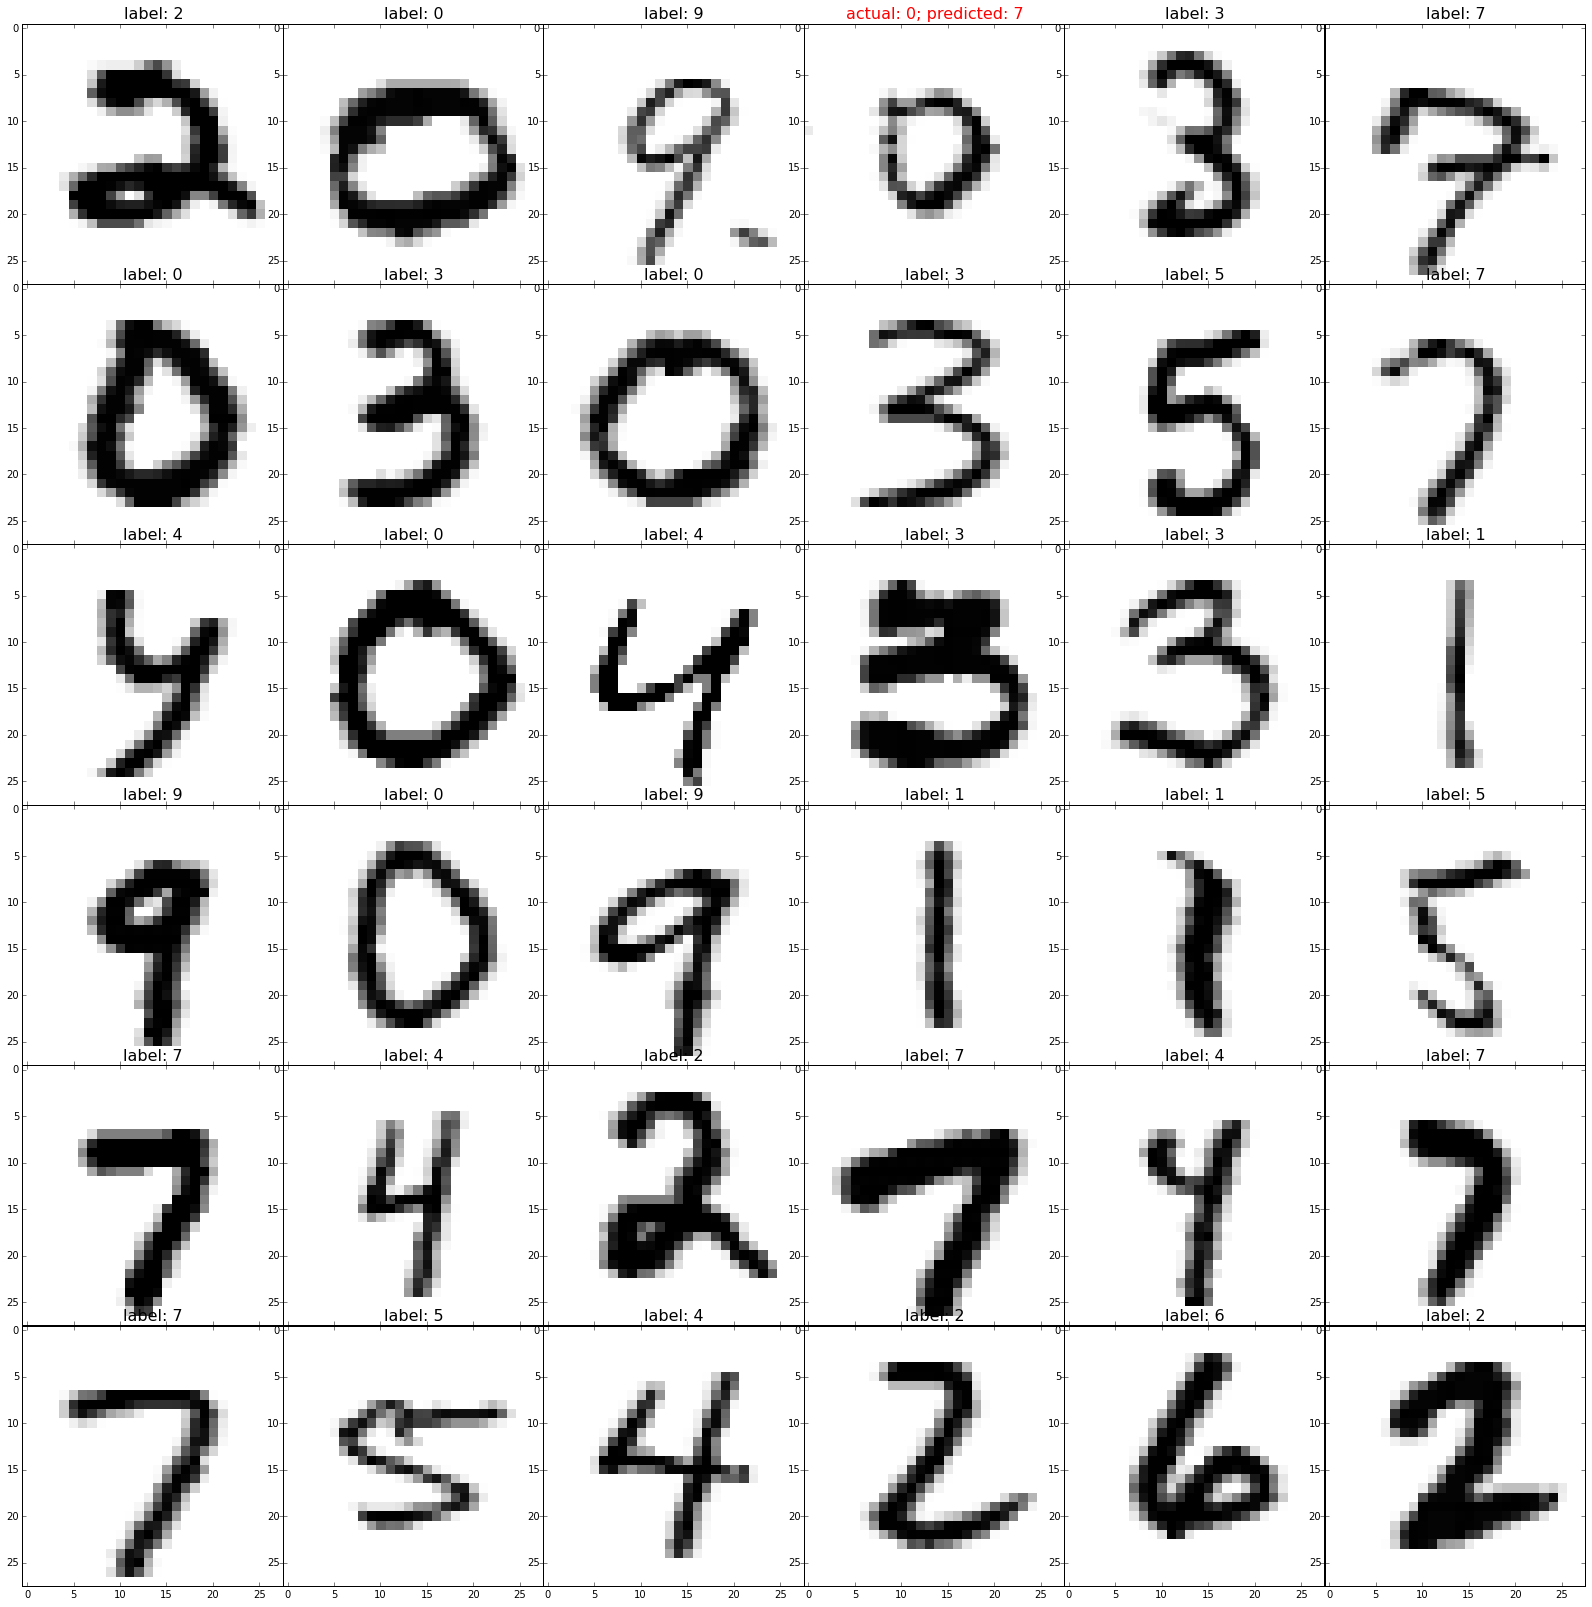

In [10]:
testY_first36 = [2,0,9,0,3,7,0,3,0,3,5,7,4,0,4,3,3,1,9,0,9,1,1,5,7,4,2,7,4,7,7,5,4,2,6,2]

print_imgs(images           = testX, 
           actual_labels    = testY_first36, 
           predicted_labels = predicted_values, 
           starting_index   = 0,
           size             = 6)

#Save the Kaggle submission file

In [11]:
with open('../kaggle/submissions/submission_GradientBoostingClassifier_deskewed.csv', 'w') as f_result:
    f_result.write('"ImageId","Label"\n')
    for i, y in enumerate(predicted_values, 1):
        f_result.write('{},"{}"\n'.format(i,y))